# What do Tim O'Reilly, Lady Gaga, and Marissa Mayer all have in common?

This IPython Notebook provides a compilation of the sample code for <a href="http://miningthesocialweb.com/">Mining the Social Web</a>'s multi-part series on exploring <a href="http://miningthesocialweb.com/category/twitter-influence/">Twitter influence</a>. The code in this notebook harvests follower IDs and the corresponding account profiles for arbitrary accounts of interest along with some initial exercises to get you busy analyzing the data. We'll applly the same "Aspire, Acquire, Analyze, Summarize" data science framework that has been presented in previous posts as a guide through this notebook.

For the educational purpose of investigating the intuition behind popularity (number of followers) as a measure of influence on Twitter with a concrete set of data, Tim O'Reilly and his followers provide the primary basis of this examination. Sample output from the analysis section of the notebook is left in place for easy review.

In the spirit of <em><a href="http://www.amazon.com/Freakonomics-Rev-Ed-Riddles-Modern-ebook/dp/B002VL1CLW/?tag=oreonbl-20">Freakonomics</a></em> (but mostly just for entertainment purposes), we'll also briefly juxtapose some of Tim O'Reilly's data with that of Lady Gaga to see what followers they have in common and even compute a Jaccard similarity score for them based on the followers that they have in common.

But a Jaccard score all by itself is no fun at all, so Marissa Mayer's data will also make a brief guest appearance so that we can make a couple of additional comparisons. The selection of Marissa Mayer seemed interesting since she's a female technologist and thus has something in common with both Tim O'Reilly and Lady Gaga (as arbitrary as that may seem.)

# Abstract

Some of the key findings that you'll learn how to reproduce and explore include:

* Approximately 50% of Tim O'Reilly's ~1.7 million followers are "suspect" in the sense that they may be inactive accounts or spam bots. Only about 15% of Marissa Mayer's followers are suspect according to the same criteria.
    * Although purely speculative, this difference *might* be explainable by a massive wave of spam-bots attacking popular users back in 2009 when Twitter experiences unprecedented user growth.
* Approximately 25% of Tim O'Reilly's "non-suspect" followers also follow Lady Gaga.
* Lady Gaga has a higher Jaccard similarity to Tim O'Reilly than to Lady Gaga. (However, Tim O'Reilly and Marissa Mayer have a *much* higher Jaccard similarity to one another than either one of them have to Lady Gaga.)
* The total number of followers that Tim O'Reilly, Marissa Mayer, and Lady Gaga have in common is about 25k. This figure represents about 5% of Marissa Mayer's total followers.

This remainder of this IPython notebook provides the source code and fodder to reproduce these results. Visit <a href="http://MiningTheSocialWeb.com">Mining the Social Web</a> for <a href="http://wp.me/p3QiJd-4k">the corresponding blog post</a> and related content.

# 1. Aspire

Let's aspire to investigate a few questions as part of a data science experiment:

* Is there a relationship between popularity and influence on Twitter?
* How influenceable are a popular Twitter user's followers?
* Do Tim O'Reilly, Lady Gaga, and Marissa Mayer have very many followers in common?
* Between Tim O'Reilly, Lady Gaga, and Marissa Mayer, which pair of users has the highest Jaccard similarity based on followers?

# 2. Acquire

Having aspired to investigate some interesting queries, let's now acquire the data to perform this investigation.

## Data Collection Machinery

We can collect the IDs for all of an account's followers by adapting the following recipes from the <a href="https://rawgithub.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/master/ipynb/html/Chapter%209%20-%20Twitter%20Cookbook.html">Twitter Cookbook (Chapter 9)</a> notebook:

* <a href="https://rawgithub.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/master/ipynb/html/Chapter%209%20-%20Twitter%20Cookbook.html#Example-1.-Accessing-Twitter's-API-for-development-purposes">Example 9-1</a>. Accessing Twitter's API for development purposes (use as-is)
* <a href="https://rawgithub.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/master/ipynb/html/Chapter%209%20-%20Twitter%20Cookbook.html#Example-7.-Saving-and-accessing-JSON-data-with-MongoDB">Example 9-7</a>. Saving and Accessing JSON Data with MongoDB (requires minor adaptations)
* <a href="https://rawgithub.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/master/ipynb/html/Chapter%209%20-%20Twitter%20Cookbook.html#Example-16.-Making-robust-Twitter-requests">Example 9-16</a>. Making robust Twitter requests (use as-is)
* <a href="https://rawgithub.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/master/ipynb/html/Chapter%209%20-%20Twitter%20Cookbook.html#Example-17.-Resolving-user-profile-information">Example 9-17</a>. Resolving user profile information (requires minor adaptations)
* <a href="https://rawgithub.com/ptwobrussell/Mining-the-Social-Web-2nd-Edition/master/ipynb/html/Chapter%209%20-%20Twitter%20Cookbook.html#Example-19.-Getting-all-friends-or-followers-for-a-user">Example 9-19</a>. Getting all friends or followers for a user (requires minor adaptations)

In [1]:
from functools import partial
from sys import maxint
import sys
import time
from urllib2 import URLError
from httplib import BadStatusLine
import json
import twitter # pip install twitter
import pymongo # pip install pymongo


def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation
    
    CONSUMER_KEY = ''
    CONSUMER_SECRET = ''
    OAUTH_TOKEN = ''
    OAUTH_TOKEN_SECRET = ''
        
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated value 
    # for wait_period if the problem is a 500 level error. Block until the rate limit 
    # is reset if a rate limiting issue (429 error). Returns None for 401 and 404 errors
    # which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print >> sys.stderr, 'Too many retries. Quitting.'
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            print >> sys.stderr, 'Encountered 401 Error (Not Authorized)'
            return None
        elif e.e.code == 404:
            print >> sys.stderr, 'Encountered 404 Error (Not Found)'
            return None
        elif e.e.code == 429: 
            print >> sys.stderr, 'Encountered 429 Error (Rate Limit Exceeded)'
            if sleep_when_rate_limited:
                print >> sys.stderr, "Sleeping for 15 minutes, and then I'll try again...ZzZ..."
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print >> sys.stderr, '...ZzZ...Awake now and trying again.'
                return 2
            else:
                raise e # Allow user to handle the rate limiting issue however they'd like 
        elif e.e.code in (500, 502, 503, 504):
            print >> sys.stderr, 'Encountered %i Error. Will retry in %i seconds' % (e.e.code,
                    wait_period)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError, e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError, e:
            error_count += 1
            print >> sys.stderr, "URLError encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
        except BadStatusLine, e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
                
def store_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint, database=None):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), "Must have screen_name or user_id, but not both"
    
    # See https://dev.twitter.com/docs/api/1.1/get/friends/ids  and
    # See https://dev.twitter.com/docs/api/1.1/get/followers/ids for details on API parameters
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, count=5000)
    
    for twitter_api_func, limit, label in [
                                 [get_friends_ids, friends_limit, "friends"], 
                                 [get_followers_ids, followers_limit, "followers"]
                             ]:
        
        if limit == 0: continue
        
        total_ids = 0
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids = response['ids']
                total_ids += len(ids)
                save_to_mongo({"ids" : [_id for _id in ids ]}, database, label + "_ids")
                cursor = response['next_cursor']
        
            print >> sys.stderr, 'Fetched {0} total {1} ids for {2}'.format(total_ids, label, (user_id or screen_name))
            sys.stderr.flush()
        
            # Consider storing the ids to disk during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                break
                print >> sys.stderr, 'Last cursor', cursor
                print >> sts.stderr, 'Last response', response

def save_to_mongo(data, mongo_db, mongo_db_coll, auth=None, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    if auth:
        db.authenticate(auth[0], auth[1])
        
    # Reference a particular collection on the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the ids
    
    return coll.insert(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, auth=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    
    if auth:
        db.authenticate(auth[0], auth[1])

    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]
    
def store_user_info(twitter_api, screen_names=None, user_ids=None, database=None):
   
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), "Must have screen_names or user_ids, but not both"
    
    items = screen_names or user_ids
    
    while len(items) > 0:
        if len(items)/100*100 % 1000 == 0:
            print >> sys.stderr, len(items), "remaining"
            
        # Process 100 items at a time per the API specifications for /users/lookup. See
        # https://dev.twitter.com/docs/api/1.1/get/users/lookup for details
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]

        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, user_id=items_str)
    
        for profile in response:            
            save_to_mongo(profile, database, 'followers_profiles')
            
# Go ahead and instantiate an instance of the Twitter API for common use
# throughout the rest of this notebook.

twitter_api = oauth_login()

## Harvesting Followers for Tim O'Reilly

Recall from previous posts in this series that harvesting followers is a two-step process. First, harvest the IDs, and then use the IDs to procure the corresponding profiles. 

First, let's get the IDs...

In [ ]:
# Harvest the follower IDS. Note that this process takes a bit of time since
# you are limited to harvesting 75k IDs per 15 minute window.
# 
# Some example accounts that we'll look at later in this notebook:
#
# Tim O'Reilly: ~1.7M followers (~6 hours)
# Marissa Mayer: ~460k followers (~1.5 hours)
# Lady Gaga: ~40M followers (~5.5 days)
#
# All in all, it takes a little over a week to harvest all of these IDs.


# Define a simple wrapper that accepts a list of screen names for convenience
# and reusability later.

def harvest_followers_ids(screen_names=[]):
    for screen_name in screen_names:
        store_friends_followers_ids(twitter_api, screen_name=screen_name, 
                                    friends_limit=0, database=screen_name)

        
harvest_followers_ids(screen_names=[ 'timoreilly' ])

print "Done"

And now, let's get the profiles...

In [ ]:
# Iterate over the IDs for each follower of Tim O'Reilly and
# lookup the profile. This process also takes some time since you are 
# limited to 18k profiles per 15 minute rate limit window. Resolving 
# all of these profiles takes a little over a day.
#
# Note that we could always opt to draw a random sample for a highly popular 
# account's followers IDs for a statistical analysis. However, be advised that
# for the sample to be truly random, you do probabably need to first pull down the
# totality of the follower IDs and then draw from that collection. Simply harvesting
# the first N followers returned by the API and using that as a sample may not be 
# sufficient, since Twitter currently returns followers in the order in which the
# follow occurred (though this is subject to change without notice.)
#
# For example, a 95% confidence interval with a 1% margin of error requires just
# under 10k items be drawn for the random sample. A 99% confidence interval with 
# a 1% margin of error requires just under 17k items be drawn for the random sample.


# Define another convenience wrapper and assume that you've already
# harvested the follower IDs for the account in question

def harvest_followers_profiles(screen_names=[]): 
    for screen_name in screen_names:
        followers_ids = load_from_mongo(screen_name, 'followers_ids')
        
        # Flattening the IDs into memory requires a generous heap space. An
        # m1.xlarge AWS node (15GB of memory) should be more than sufficient
        # and spot prices are typically around $0.05/hr
        
        all_ids = [ _id for ids_batch in followers_ids for _id in ids_batch['ids'] ]
        
        store_user_info(twitter_api, user_ids=all_ids, database=screen_name)

        
harvest_followers_profiles(screen_names=[ 'timoreilly' ])

print "Done."

That all the data that we need to narrow in on Tim O'Reilly's account and investigate the relationship between popularity on Twitter and influence. (The functions from this section are trivially reusable for harvesting Lady Gaga's and Marissa Mayer's data.)

# 3. Analyze

Now that we have the data, let the analysis begin!

## Taking a closer look at Tim O'Reilly's followers

This section is a template for how you could take a closer look at an account's followers. The possibilities are endless, and we'll just work through a few examples to gain better intuition about Twitter popularity as an indicator of influence. In other words, how much influence can be exerted on these followers? Are all ~1.7M of his followers likely to be influenceable. It may be helpful to review the initial discussion  on <a href="http://miningthesocialweb.com/2013/09/19/computing-twitter-influence-part-1/">forging a base metric for influence</a> that started this series if you don't recall that discussion.

In [2]:
# Compute a list containing the number of followers for each of Tim O'Reilly's own followers.
# Sort it for convenience of slicing and plotting.

timoreilly_followers_counts = sorted([f['followers_count'] 
                                      for f in load_from_mongo('timoreilly', 'followers_profiles', 
                                                         projection={'followers_count' : 1, '_id' : 0})])

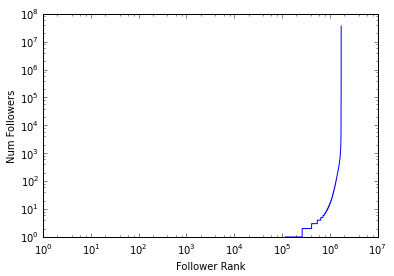

In [3]:
# Now, let's plot the list to gain some initial intuition about the curve.

plt.loglog(timoreilly_followers_counts)
plt.ylabel("Num Followers")
plt.xlabel("Follower Rank")

It appears that the curve resembles that of a "power law" distribution. In other words, there are some extreme outliers that are wildly popular, but most of the area "under the curve" lies within the "long tail", though it's a bit hard to see in this plot.

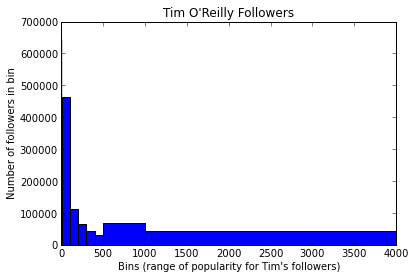

In [4]:
# Now knowing that the curve resembles that of a "power law" and that
# most of the substance is in the "long tail", let's zoom in on some the tail 
# with a histogram.

# The resolution for a histogram displaying the full data set would be less than 
# useful to look at since the x-axis would stretch all the way out to accomodate 
# the outliers. (Try it.)
# plt.hist(timoreilly_followers_counts)

# So, hack the display a bit so that we only visualize 99% of the data and avoid the
# outliers on the upper extreme. It's easy enough to produce a separate plot of them

bins = [0,5,10,100,200,300,400,500,1000,4000]
plt.hist(timoreilly_followers_counts[:len(timoreilly_followers_counts)/100*99], bins=bins)


plt.title("Tim O'Reilly Followers")
plt.xlabel('Bins (range of popularity for Tim\'s followers)')
plt.ylabel('Number of followers in bin')

Hmm, there are a lot of followers that don't have many followers at all as we can see from the left side of the histogram. It appears that a highly disporportionate number of Tim O'Reilly's followers have fewer than 10 followers of their own. These *could* be legitimate accounts (active and not a spam-bot), but let's tentatively consider these followers 'suspect' and take a closer look at them.

In [5]:
# Let's start with a very base assumption for the time being: 
# any follower with less than 10 followers of their own is "suspect" in the
# sense that this follower may be an inactive account, spambot, or abandoned account.
# Regardless, it probably offers no meaningful influence. (Although this assumption 
# may be a bit naive, it seems a reasonable starting point for now.)

MIN = 10
timoreilly_suspect_followers = [f 
                                for f in load_from_mongo('timoreilly', 'followers_profiles', 
                                                          projection={'followers_count' : 1, 'id' : 1, '_id' : 0})
                                if f['followers_count'] < MIN]

print "Tim O'Reilly has {0} 'suspect' followers for MIN={1}".format(len(timoreilly_suspect_followers), MIN)

Tim O'Reilly has 877457 'suspect' followers for MIN=10


Whoa! Approximately 50% of Tim O'Reilly's followers are suspect. Let's narrow in on them some more by plotting a histogram to zoom in a bit more on the data.

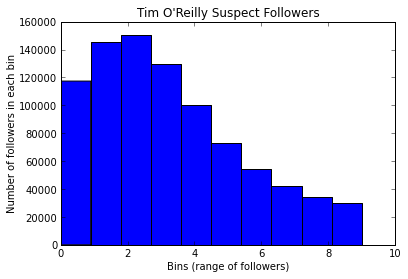

In [6]:
# What does a plot of these 'suspect' followers look like?

timoreilly_suspect_followers_counts = sorted([f['followers_count'] 
                                              for f in timoreilly_suspect_followers], reverse=True)

plt.hist(timoreilly_suspect_followers_counts)
plt.title("Tim O'Reilly Suspect Followers")
plt.xlabel('Bins (range of followers)')
plt.ylabel('Number of followers in each bin')

Interesting. So *most* of the suspect followers appear to have 5 or fewer followers, so *MIN=5* might be a threshold to keep in mind. Let's gain a little more insight by calculating accumulation of these suspect followers for follower counts in the range of 1 to 5.

In [7]:
# A little more analysis of how the distribution breaks down
print "{0} of Tim O'Reilly's followers have 0 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 1]))

print "{0} of Tim O'Reilly's followers have 1 follower"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c <= 1]))

print "{0} of Tim O'Reilly's followers have less than 3 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 3]))

print "{0} of Tim O'Reilly's followers have less than 4 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 4]))

print "{0} of Tim O'Reilly's followers have less than 5 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 5]))

117370 of Tim O'Reilly's followers have 0 followers
262417 of Tim O'Reilly's followers have 1 follower
412973 of Tim O'Reilly's followers have less than 3 followers
542748 of Tim O'Reilly's followers have less than 4 followers
643068 of Tim O'Reilly's followers have less than 5 followers


Bottom line: given a threshold of *MIN=5*, about 38% of Tim O'Reilly's followers may not really be influenceable followers at all. We'd need to do some more analysis to get a better idea of what other features we could inspect to determine the likelihood of these followers being spam-bots. I have completed some non-trivial analysis that will be presented "soon", but this is a good place for you to jump in. Data mining is not a spectator sport!

Some recommended exercises for further analysis:

* When were these suspect accounts created? (What you'll discover is that the majority of them were all created in the year 2009. Why might this be? Twitter experienced <a href="http://techcrunch.com/2009/10/05/twitter-data-analysis-an-investors-perspective-2/">unprecedented growth</a> in early 2009. Perhaps there was an attach of spam bots that it was not yet well equipped to handle?)
* When did these suspect accounts last tweet? Is there a correlation to account creation time?
* How many of these accounts have changed profile images to something other than the default profile image?
* Who are the most popular accounts that follow Tim O'Reilly and how influenceable are they likely to be? (One of these followers is high among the most popular users in the world -- almost as popular as Lady Gaga.)

We already have all of the data on hand to answer these questions and much more from the account profiles. The answers to these questions may surprise you.

A more advanced exercise:

* Try developing a heuristic (or better yet, using some supervised machine learning to build a classifier) to determine whether or not an account is likely to be spam bot as opposed just being an inactive account

## What do Tim O'Reilly and Lady Gaga have in common?

You can trivially reuse the previously defined havesting functions to pull account data for Lady Gaga's account or any other account. Let's assume that you've done that already. It takes just under a week to harvest all of her follower IDs, which is all that we really need since we already have all of the full profiles for Tim O'Reilly's followers. We can compute many interesting things without the full profiles for the 40M+ followers, and draw random samples from the full population of follower IDs for testing hypotheses that involve concrete account data.

In this section, we'll compute the followers that they have in common as well as the Jaccard similarity score. (Note that computing the common followers is just a set intersection and is not normalized whereas Jaccard similarity normalizes by introducing a denominator that is the union of the two sets.)

### Computing Tim O'Reilly and Lady Gaga's Common Followers (Set Intersection)

Calculating common followers between two or more accounts is as simple as applying a set intersection operation.

In [8]:
# Create sets of ids for each account of interest by flattening out the lists for each
# request that was stored in MongoDB. (The maximum document size in MongoDB is ~16MB so
# there would have been little to gain by trying to store them in a flatter structure 
# from the outset since multiple documents would have inevitably been required.)

timoreilly_followers_ids = set([fid
                 for ids in load_from_mongo('timoreilly', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

ladygaga_followers_ids = set([fid
                 for ids in load_from_mongo('ladygaga', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

# Now, calculate the number of followers in common between each person of interest
# by using set intersections.

timoreilly_ladygaga_common_followers_ids = timoreilly_followers_ids & ladygaga_followers_ids

print "Tim O'Reilly and Lady Gaga have {0} followers in common."\
.format(len(timoreilly_ladygaga_common_followers_ids))

Tim O'Reilly and Lady Gaga have 261450 followers in common.


Interesting. It seems like more than 250k followers is a non-trivial number of followers to have in common. Let's investigate how many of the common followers with Lady Gaga are from Tim O'Reilly's suspect set of followers.

### Do suspect followers dominate Tim O'Reilly's set of followers in common with Lady Gaga?

In [9]:
# So, how many of Tim O'Reilly's suspect followers are in common with
# Lady Gaga? It would be helpful to know if the followers that they have in common
# are or aren't domainted by the suspect followers.

# For convenience, let's carve out just the IDs for easy setwise comparison
timoreilly_suspect_followers_ids = set([f['id'] for f in timoreilly_suspect_followers])

print "{0} of Tim O'Reilly's 'suspect' followers are from the set that's in common with Lady Gaga's followers"\
.format(len(timoreilly_suspect_followers_ids & timoreilly_ladygaga_common_followers_ids))

38575 of Tim O'Reilly's 'suspect' followers are from the set that's in common with Lady Gaga's followers


It would appear that the set of common followers is not dominated by the suspect followers, though there are certainly some. Roughly 15% of the common followers are from the suspect set, leaving 85% (~225k) outside of the suspect category.

## Jaccard Similarity

The Jaccard similarity is perhaps a more useful similarity score to employ when comparing sets of things than just a setwise intersection. For our context, Jaccard similarity is defined as the number of followers in common between the accounts divided by the combined number of unique followers if you were to merge the followers for each of those accounts. The effect here is that you are dividing the number of followers in common by a normalization term. A normalization term is appropriate, especially in this circumstance, because the cardinality of each set of followers is so different.

Computing the Jaccard similarity between any two sets isn't very helpful unless you have some other reference points for comparison, so let's introduce another Twitter account that has something in common with both Tim O'Reilly and Lady Gaga. Marissa Mayer would be an interesting choice since she's a "technology celebrity" like Tim O'Reilly but also a female. (Admittedly that's a contrived explanation, but the original juxtaposition isn't any less contrived, so let's go with it and see what happens.)

Recall that you can harvest all of Marissa Mayer's followers and the corresponding account profiles per the functions previously introduced and hack on the data to produce the very same working variables that we've been working with so far (and then some.)

In [10]:
# There are non-trivial numbers of followers in common, but computing the set
# intersection doesn't take into account the size of any given set, so let's
# calculate the Jaccard similarity score, which provides a sort of
# normalization. See http://en.wikipedia.org/wiki/Jaccard_index for details.
# In short, it's a similarity measurement. The higher the score, the more
# similar two sets are in comparison to two other sets.

def jaccard(x,y): return 1.0*len(x & y) / len(x | y)

timoreilly_ladygaga_jaccard = jaccard(timoreilly_followers_ids, ladygaga_followers_ids)
print "Tim O'Reilly and Lady Gaga's Jaccard Index: {0}".format(timoreilly_ladygaga_jaccard)

# Need to define this variable, assuming you've pulled down the data for this account

marissamayer_followers_ids = set([fid
                 for ids in load_from_mongo('marissamayer', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

marissamayer_ladygaga_jaccard = jaccard(marissamayer_followers_ids, ladygaga_followers_ids)
print "Marissa Mayer and Lady Gaga's Jaccard Index: {0}".format(marissamayer_ladygaga_jaccard)

timoreilly_marissamayer_jaccard = jaccard(timoreilly_followers_ids, marissamayer_followers_ids)
print "Tim O'Reilly and Marissa Mayer's Jaccard Index {0}".format(timoreilly_marissamayer_jaccard)

Tim O'Reilly and Lady Gaga's Jaccard Index: 0.0062353871157
Marissa Mayer and Lady Gaga's Jaccard Index: 0.00202385195072
Tim O'Reilly and Marissa Mayer's Jaccard Index 0.0492571582527


It's not that surprising that Tim O'Reilly and Marissa Mayer have a much higher similarity score to one another than either of them do to Lady Gaga, is it? Given that their statuses as "celebrity technologists" or "business leaders" (amongst other things) are going to drive more interest than a basic variable like gender, the results are as we'd probably have expected them to be.

That said, how do we account for the (slightly) higher similarity score between Tim O'Reilly and Lady Gaga as compared to Lady Gaga and Marissa Mayer? One thought is that Tim O'Reilly's base of followers is substantially larger than Marissa Mayer's so the sheer numbers are probably the deciding factor.

Let's re-run the numbers after adjusting for suspect followers to see if anything changes. (Although we aren't adjusting Lady Gaga's set of followers IDs by subtracting out the suspect followers, this should probably be fine for relative comparisons since it's a constant factor for each of the calculations.)

In [21]:
timoreilly_followers_ids_not_suspect = timoreilly_followers_ids - timoreilly_suspect_followers_ids

timoreilly_ladygaga_jaccard_not_suspect = jaccard(timoreilly_followers_ids_not_suspect, ladygaga_followers_ids)
print "Tim O'Reilly and Lady Gaga's Jaccard Index adjusted for suspect followers: {0}"\
.format(timoreilly_ladygaga_jaccard_not_suspect)

# Need to define this variable, assuming you've pulled down the data for this account

marissamayer_followers_ids = set([fid
                 for ids in load_from_mongo('marissamayer', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

marissamayer_followers_ids_not_suspect = marissamayer_followers_ids - marissamayer_suspect_followers_ids

marissamayer_ladygaga_jaccard_not_suspect = jaccard(marissamayer_followers_ids_not_suspect, ladygaga_followers_ids)
print "Marissa Mayer and Lady Gaga's Jaccard Index adjusted for suspect followers: {0}"\
.format(marissamayer_ladygaga_jaccard_not_suspect)

timoreilly_marissamayer_jaccard_not_suspect = jaccard(timoreilly_followers_ids_not_suspect, marissamayer_followers_ids)
print "Tim O'Reilly and Marissa Mayer's Jaccard Index adjusted for suspect followers {0}"\
.format(timoreilly_marissamayer_jaccard_not_suspect)

Tim O'Reilly and Lady Gaga's Jaccard Index adjusted for suspect followers: 0.00542391691954
Marissa Mayer and Lady Gaga's Jaccard Index: 0.00177032283699
Tim O'Reilly and Marissa Mayer's Jaccard Index 0.0825309743004


It would appear that the relative comparisons don't change if adjusting for suspect followers. Tim O'Reilly and Lady Gaga are more similar based upon their followers than are Lady Gaga and Marissa Mayer.

## What do Tim O'Reilly, Lady Gaga, and Marissa Mayer all have in common?

Given the previous findings, let's now return to the original questions and compute the set of followers that Tim O'Reilly, Lady Gaga, and Marissa Mayer all have in common by applying the set intersection operator.

In [32]:
# Calculate the number of followers in common between each person of interest
# by using set intersections.

all_common_followers_ids = marissamayer_followers_ids & timoreilly_followers_ids & ladygaga_followers_ids

print "Tim O'Reilly, Lady Gaga, and Marissa Mayer have {0} followers in common."\
.format(len(all_common_followers_ids))

Tim O'Reilly, Lady Gaga, and Marissa Mayer have 26307 followers in common.


Tim O'Reilly, Lady Gaga, and Marissa Mayer share a little over 26k followers in common, which is approximately 5% of Marissa Mayer's entire follower base. But how many of these common followers may be suspect? Let's backup and compute Marissa Mayer's suspect followers so that we can find out.

Marissa Mayer has 69538 'suspect' followers for MIN=10


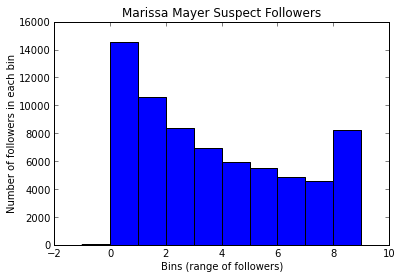

In [12]:
# Let's recycle some code to compute Marissa Mayer's suspect followers

MIN = 10
marissamayer_suspect_followers = [f 
                                for f in load_from_mongo('marissamayer', 'followers_profiles', 
                                                          projection={'followers_count' : 1, 'id' : 1, '_id' : 0})
                                if f['followers_count'] < MIN]

print "Marissa Mayer has {0} 'suspect' followers for MIN={1}".format(len(marissamayer_suspect_followers), MIN)

marissamayer_suspect_followers_counts = sorted([f['followers_count'] 
                                              for f in marissamayer_suspect_followers], reverse=True)

plt.hist(marissamayer_suspect_followers_counts)
plt.title("Marissa Mayer Suspect Followers")
plt.xlabel('Bins (range of followers)')
plt.ylabel('Number of followers in each bin')

Whoa! Only ~70k of Marissa Mayer's followers are suspect when using the same criteria that we applied to Tim O'Reilly. This number as a percentage is significantly lower than Tim O'Reilly's. If you take a closer look at their account data you'll see that Tim O'Reilly was a very early user, creating an account in March 2007, and was already a popular and well-known user by 2009 when there was significant growth (and may have been a spam bot attack.) Marissa Mayer, on the other hand, didn't create an account until late November 2008, so she would likely not yet have been a popular user in early 2009 when the sharp growth occurred.

Let's subtract out these suspect followers from the previously computed common set between Tim O'Reilly and Lady Gaga to see how many remain.

In [29]:
marissamayer_suspect_followers_ids = set([f['id'] for f in marissamayer_suspect_followers])

all_common_followers_ids_not_suspect = all_common_followers_ids - \
                                       (timoreilly_suspect_followers_ids | marissamayer_suspect_followers_ids)

print "Tim O'Reilly, Lady Gaga, and Marissa Mayer have {0} non-suspect followers in common."\
.format(len(all_common_followers_ids_not_suspect))

Tim O'Reilly, Lady Gaga, and Marissa Mayer have 25470 non-suspect followers in common.


It appears that the vast majority of the common followers are not suspect at all and may be active users! In other words, Tim O'Reilly, Lady Gaga, and Marissa Mayer have 25k followers in common that have passed the initial test of scrutiny.

## Rewind: Wrapping up a few loose ends

Before wrapping up, there are just a few additional unanswered questions that we can answer in order to create a little more symmetry and closure for some of the comparisons. In particular, we have the data and variables already defined to answer these questions:

* How many of Marissa Mayer's followers follow Lady Gaga?
* How many followers do Tim O'Reilly and Marissa Mayer have in common?

In [34]:
marissamayer_ladygaga_followers_ids = marissamayer_followers_ids & ladygaga_followers_ids
marissamayer_ladygaga_followers_ids_not_suspect = marissamayer_ladygaga_followers_ids - marissamayer_suspect_followers_ids
                                                  

timoreilly_marissamayer_followers_ids = timoreilly_followers_ids & marissamayer_followers_ids
timoreilly_marissamayer_followers_ids_not_suspect = timoreilly_marissamayer_followers_ids - marissamayer_suspect_followers_ids
                                                    

print "Marissa Mayer and Lady Gaga have {0} followers in common. {1} of them are not suspect."\
.format(len(marissamayer_ladygaga_followers_ids), len(marissamayer_ladygaga_followers_ids_not_suspect))    
    
print "Tim O'Reilly and Marissa Mayer have {0} followers in common. {1} of them are not suspect."\
.format(len(timoreilly_marissamayer_followers_ids), len(timoreilly_marissamayer_followers_ids_not_suspect))

Marissa Mayer and Lady Gaga have 82553 followers in common. 72107 of them are not suspect.
Tim O'Reilly and Marissa Mayer have 99457 followers in common. 94612 of them are not suspect.


Recalling that more than 225k of Tim O'Reilly's non-suspect followers also follow Lady Gaga (~25% of his non-suspect follower base), we can now see that ~72k of Marissa Mayer's followers also follow Lady Gaga (~18% of her non-suspect follower base.)

Marissa Mayer and Tim O'Reilly have approximately 100k common followers between them with about 95k of these common followers passing the test of scrutiny.

## Where to go from here

There are countless possibilities for exploring the data, and I hope that this notebook has given you more ideas than you know what to do with. Although we've just considered a narrow dimension of it, there is much, much more tucked away in the account profiles.

Enjoy the process of extending this notebook and stay tuned at http://MiningTheSocialWeb.com for more content like it. If there is sufficient interest, there may be an encore presentation that picks up from here.

Enjoy!

Suggested exercises:

* Apply similar analysis for the accounts that Tim O'Reilly, Lady Gaga, and Marissa Mayer are following (the accounts that they are *interested* in.) How influenceable are these accounts? What metrics would you apply to try and make this determination?
* Would you expect that a higher percentage of females might follow Marissa Mayer than Tim O'Reilly? (You can analyze first names to get a reasonable idea of whether or not this is the case. See http://tedwise.com/check-name for a list of fist names that you can use.)
* Pick a figure of your own choosing and introduce them to the comparison matrix. Who are they most similar to based upon the Jaccard similarity of their followers?

# 4. Summarize

Although there are numerous possibilities for quite interesting analysis, the scope of this notebook was intentionally kept fairly narrow, and the objective was more to whet your appetite for analyzing social web data than to rigorously *prove* anything. That said, we did observe a few interesting things:

* **Approximately 50% of Tim O'Reilly's followers are suspect**. In other words, these "users" may not be users at all. They may be spam-bots or abandoned accounts who are not influenceable at all.

* In contrast, we discovered that **only ~15% of Marissa Mayer's followers were suspect** when applying the same criteria as that of Tim O'Reilly. 

    * Although purely speculative at this point, **there may have been a spam-bot attack in early 2009** that explains this given that the majority of Tim O'Reilly's suspect users are from that year, which is the same year that Twitter experiences unprecedented user growth. Further investigation would be needed to say for sure. (Marissa Mayer wouldn't yet have been a popular or well-known Twitter user back then since she didn't create an account until late 2008. Tim O'Reilly, on the other hand, was already an established and well-known user who would have been a ripe target for spam-bots.)

* Tim O'Reilly and Lady Gaga have more than 250k followers in common with almost 225k of them passing the test of scrutiny. What's interesting about this finding is that it means that **roughly 25% of Tim O'Reilly's followers also follow Lady Gaga as compared to 18% for Marissa Mayer** once you filter out the suspect accounts.

* Tim O'Reilly and Marissa Mayer have about 100k followers in common with 95k of these followers being non-suspect.

* We computed Jaccard similarity for the combinations of Tim O'Reilly, Lady Gaga, and Marissa Mayer. Not too surprisingly, **Tim O'Reilly and Marissa Mayer had a higher Jaccard similarity than the other two possible combinations involving Lady Gaga**.

* **Tim O'Reilly, Lady Gaga, and Marissa Mayer have more than 25k total followers in common** that have passed the initial test of scrutiny.

See <a href="http://wp.me/p3QiJd-4k">http://wp.me/p3QiJd-4k</a> for a more detailed write-up of this summary.

# Recommended Links

* <a href="http://MiningTheSocialWeb.com">Mining the Social Web - Blog</a>
* <a href="http://miningthesocialweb.com/quick-start/">Mining the Social Web - Quick Start Guide</a>
* <a href="http://bit.ly/MiningTheSocialWeb2E">Mining the Social Web - GitHub</a>
* <a href="http://bit.ly/135dHfs">Mining the Social Web - Book (O'Reilly Media)</a>
* <a href="http://amzn.to/GPd59m">Mining the Social Web - Book (Amazon)</a>